# Heali<>Yelp Challenge

### Problem Statement :
Build a relevency engine to perform review summarization in the form of K tips for a given restaurant.


### Dataset:
Dataset Link - https://www.yelp.com/dataset

The dataset is provided by Yelp, which is a business directory service and crowd-sourced review forum. This dataset 192,609 businesses and 6,685,900 reviews. The data is describes the business with different attributes like hours, parking, availability, and ambience. 

Here, we will not be analysing the data completely, but just few important analysis which will help us reach to our goal.


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import collections
import re
import sys
from datetime import datetime
import networkx as nx
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from gensim.summarization.summarizer import summarize
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image
from IPython.core.display import HTML 
start = datetime.now()

C:\Users\doshi\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\doshi\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Data Extraction:

The downloaded dataset file is a json file, which is a collection of information about all the business,reviews,tip,users and check-in data.The whole dataset is sized 8GB. Before exploring the data, it is important to bifurcate the whole dataset to particualer dataset for convinence. We just need the data about the businesses and reviews.

We seperate the dataset into particualr, business and reviews dataset and convert it to .csv form for tabular structure. We get yelp_business.csv and yelp_review.csv.

**yelp_business.csv** has 174K rows and 13 coloumns. There are 174k Businesses.

**yelp_review.csv** has 6M rows and 9 coloumns.

In [2]:
dfb = pd.read_csv('yelp_business.csv')
dfr = pd.read_csv('yelp_review.csv',nrows=1000000)

My computer has a RAM of 8GB. Memory is insufficient to load all the 6M rows of reviews in the notebook.
Hence, I *sample* the data. I take **1M rows in reviews**. Because our data is not dependent on the rest of the data in the dataset ,we can sample the data in any way. If it would have been a time-series data, we cannot just sample the data in a random way.

#### How the Data looks:

**Business dataset:**

In [3]:
print('It has {} rows and {} columns'.format(dfb.shape[0],dfb.shape[1]))
dfb.head()

It has 174567 rows and 13 columns


,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


There are many irrelevant features, which are not needed for our objective. Hence, we remove those columns

In [4]:
dfb = dfb.drop(columns=['neighborhood','address','city','state','postal_code','latitude','longitude','is_open','categories'])

**Review Dataset:**

In [5]:
print('It has {} rows and {} columns'.format(dfr.shape[0],dfr.shape[1]))
dfr.head()

It has 1000000 rows and 9 columns


,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


We remove the irrelevant columns:


In [6]:
dfr = dfr.drop(columns=['user_id','date','useful','funny','cool'])

Because we have just taken 1M rows out of 6M rows, there will be many businesses whose reviews is not present in our data. Hence we remove those businesses from our dataset as they are not useful for us.
This will help us to improve the **memory constraint**.

In [7]:
biz_id_freq = dfr['business_id'].value_counts().to_dict() 
dfb['new_review_count'] = dfb['business_id'].map(biz_id_freq)
dfb.head()

,business_id,name,stars,review_count,new_review_count
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",4.0,22,6.0
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",3.0,11,2.0
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",1.5,18,3.0
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",3.0,9,2.0
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",3.5,116,30.0


We can compare the number of reviews in our dataframe with the original dataset.

**review_count** shows the number of reviews for the business in 6M dataset.

**new_review_count** shows the number of reviews for the business in 1M dataset.

The best way to check if the data is either **balanced or imbalanced** is by looking at the frequency of the ratings for all the businesses. Hence we do countplot on the feature 'stars'. If we see for a highy dominant rating, it means it is an imbalanced data. 

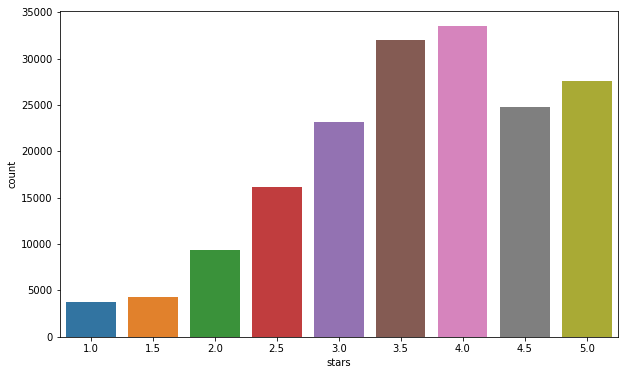

In [8]:
dfb['stars'].nunique()
plt.figure(figsize=(10,6)) # To visualise the frequency of the stars.
sns.countplot(x='stars',data=dfb);

**No dominance**, hence, we have a **balanced data**.

We sort the business dataframe by new_review_count, so that we get top reviewed businesses.

In [9]:
dfb = dfb.sort_values(['new_review_count'],ascending=False)
dfb = dfb.dropna(axis = 0)
print('After deletion of non reviewed Business, we have {} rows and {} columns'.format(dfb.shape[0],dfb.shape[1]))

After deletion of non reviewed Business, we have 136032 rows and 5 columns


**Top 100 business** that has maximum reviews in our updated Review Dataframe

In [10]:
top_business = []
for x in list(biz_id_freq)[0:101]:
    top_business.append(x)

# Tf-Idf + N-gram Model

We have represented the text in a vector representation using **Tf-Idf score**. We can ouput using any N (N<=length of the review). I have used *bi-grams and tri-grams* to get the highest frequency word phrase in each business. 

Output has top 5 reviews with their Tf-Idf Score. The reviews are sorted rank wise (top tip is ranked 1).

Considering **top 3 businesses**: 

In [11]:
def extract_top_bigram_tips(id):
    review = dfr[dfr['business_id']==id]['text']
    tfidf_vec = TfidfVectorizer(stop_words='english',ngram_range=(2,2))# Limiting it to bi-gram
    review_vec = tfidf_vec.fit_transform(review) # Finding Tf-Idf Score
    tips = tfidf_vec.get_feature_names() 
    tf_idf_sum = review_vec.sum(axis=0).A1
    data = pd.DataFrame()
    data['tips'] = tips
    data['score'] = tf_idf_sum
    data = data.sort_values('score', ascending=False).reset_index(drop=True)
    return data.head()

def extract_top_trigram_tips(id):
    review = dfr[dfr['business_id']==id]['text']
    tfidf_vec = TfidfVectorizer(stop_words='english',ngram_range=(3,3))
    review_vec = tfidf_vec.fit_transform(review)
    tips = tfidf_vec.get_feature_names()
    tf_idf_sum = review_vec.sum(axis=0).A1
    data = pd.DataFrame()
    data['tips'] = tips
    data['score'] = tf_idf_sum
    data = data.sort_values('score', ascending=False).reset_index(drop=True)
    return data.head()


def print_top_tips(id):
    bigram_tips = extract_top_bigram_tips(id)
    trigram_tips = extract_top_trigram_tips(id)
    print('----Most Common Bigram tips----')
    for index, row in bigram_tips.iterrows():
        print('{} : {}'.format(row['tips'], row['score']))
    print()
    print('----Most Common Trigram tips----')
    for index, row in trigram_tips.iterrows():
        print('{} : {}'.format(row['tips'], row['score']))

In [12]:
starttime = datetime.now()
for i in top_business[:3]:
    print("Tips for Business ID : {}".format(i))
    print_top_tips(i)
    print("")

print('Time taken to run this algorithm : {}'.format(datetime.now() - starttime))

Tips for Business ID : 4JNXUYY8wbaaDmk3BPzlWw
----Most Common Bigram tips----
mon ami : 14.176187281810291
ami gabi : 12.780870675478761
onion soup : 10.939921863346838
bellagio fountains : 10.690860121041577
las vegas : 9.623049932919038

----Most Common Trigram tips----
mon ami gabi : 12.107743832810224
french onion soup : 8.492288194779924
view bellagio fountains : 5.075744889076769
corned beef hash : 3.3894966330212015
bloody mary bar : 3.168038538485106

Tips for Business ID : RESDUcs7fIiihp38-d6_6g
----Most Common Bigram tips----
crab legs : 18.557035178972296
best buffet : 14.467913605948915
prime rib : 10.842212549353572
buffet vegas : 9.823677298625885
las vegas : 8.70899505087716

----Most Common Trigram tips----
best buffet vegas : 5.5430541845410275
king crab legs : 4.660398476807368
best buffet ve : 4.069755190729335
buffet las vegas : 3.5945299172721468
best buffet las : 2.7404548104126487

Tips for Business ID : K7lWdNUhCbcnEvI0NhGewg
----Most Common Bigram tips----
wick

**Word Cloud** is a type of visualisation where the highest frequency word has a bigger font size and there is no overlapping between the words in an image. Frequency and font size are directly proportional. Below, we build a word cloud for the particular Business we used above with **Business ID = '4JNXUYY8wbaaDmk3BPzlWw'**, with 1416 reviews, our top business.

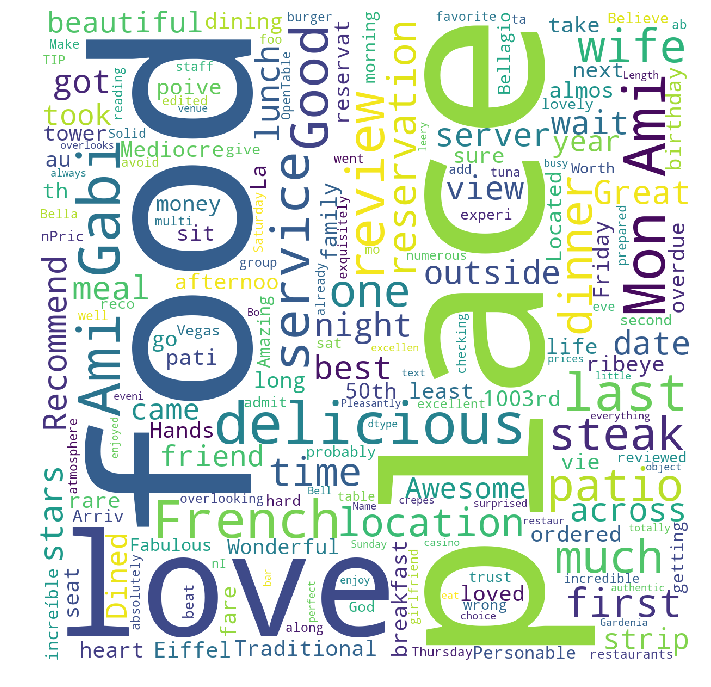

In [13]:
id ='4JNXUYY8wbaaDmk3BPzlWw' 
review = dfr[dfr['business_id']==id]['text']
plt.figure(figsize=(12,12))
wordcloud = WordCloud(background_color='white',width=1200,stopwords = STOPWORDS,height=1200).generate(str(review))
plt.imshow(wordcloud)
plt.axis('off');

* Reviews alone can give us much information and hence, we might not include the Tip.json file as it would increse the memory and decrese the RAM capacity of the system.

### Finding the Polarity of the reviews using TextBlob:

Polarity is in the range of [-1,1].

**-1 = Very negative review**

**0 = Neutral**

**1 = Very positive review**

Find the sentiment of the review by:

In [14]:
starttime = datetime.now()
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

dfr['polarity'] = dfr['text'].apply(detect_polarity)
print('Time taken to run : {}'.format(datetime.now()-starttime))

''' Warning: This takes a lot of time to run as we are traversing 1M rows'''

Time taken to run : 0:21:57.810668


' Warning: This takes a lot of time to run as we are traversing 1M rows'

In [15]:
dfr.head()

,review_id,business_id,stars,text,polarity
0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,Super simple place but amazing nonetheless. It...,0.251389
1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,Small unassuming place that changes their menu...,0.291667
2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,Lester's is located in a beautiful neighborhoo...,0.295833
3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,Love coming here. Yes the place always needs t...,0.192857
4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,Had their chocolate almond croissant and it wa...,0.530000


#### How the polarity is distributed:

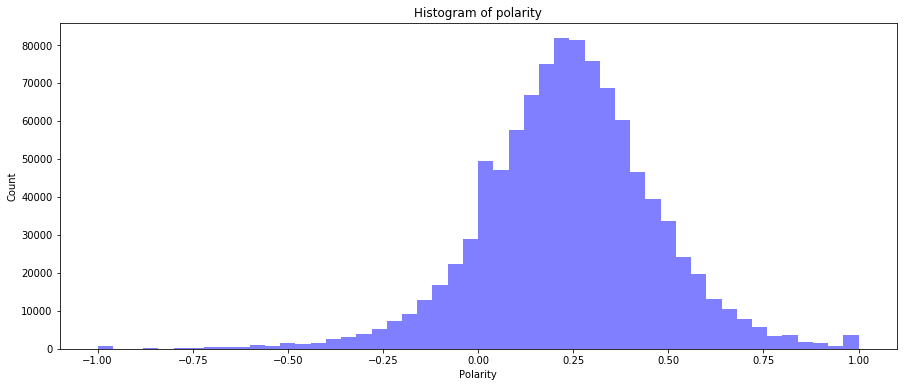

In [16]:
num_bins = 50
plt.figure(figsize=(15,6))
plt.hist(dfr['polarity'], num_bins, facecolor='blue',alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show()

We can visualise that the most of the reviews have an above neutral polarity and there are also points, where the polatiry is 1, that means a very positive review.

#### Visualising how Stars and Polarity relate to each other:

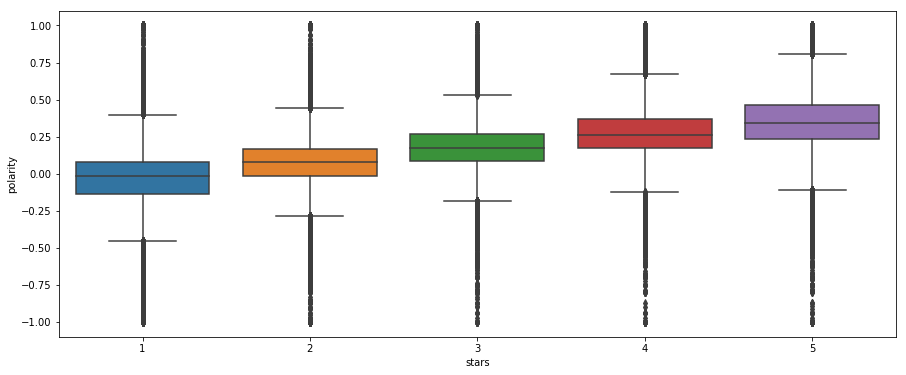

In [17]:
plt.figure(figsize=(15,6))
sns.boxplot(x='stars', y='polarity', data=dfr)
plt.show();

The median for Star 1 is neutral but we can also see there are plenty of outliers. Rest observations are very obvious.

## Review Summarisation using Glove word Embedding and Text Rank Algorithm

Let us take some Business ID and find the most relevant reviews from all its reviews and **summarise the top relevent reviews**.



We take a Business ID having approx **100 reviews**. So, *we select 5 most relevent reviews and summarise them.*

In [18]:
idb = '1CR2ddUcjYYwRd5JLtiRrw' # Taking a Business ID
text = dfr[dfr['business_id']==idb]['text'] # All reviews for the particualr id

starttime=datetime.now()
sentences = []
for s in text:
    sentences.append(nltk.sent_tokenize(s))
sentences = [y for x in sentences for y in x] # list in a row
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ") # Cleaning the text : Lowercase  
clean_sentences = [s.lower() for s in clean_sentences]
stop_words = stopwords.words('english')

def remove_stopwords(sen): # Removing Stop words
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences] # Removing Stop words from the Reviews.
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')# The file is a pre-trained glove model helps in embedding words accurately.
for line in f:                                  # The bigger the trained model we have, better neural network is learnt
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

sentence_vectors = []
for i in clean_sentences: # Appending all the sentence vectors after Glove embedding
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)

sim_mat = np.zeros([len(sentences), len(sentences)]) # Creating a matrix to find the cosine similarity


for i in range(len(sentences)): #Calaculating the Cosine similarity
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

nx_graph = nx.from_numpy_array(sim_mat) # Text Rank Algorithm : representing each sentence as a node in a graph  
scores = nx.pagerank(nx_graph)

ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

sentence_array = np.asarray(ranked_sentences)
print("Top 5 tips for this Business is:")
print("--------------------------------------------------------")
for i in range(1,6):
    print("Rank : {}".format(i))
    print("Score : {}".format(sentence_array[i][0]))
    print(sentence_array[i][1])
print(" ")
print("Time taken to run this algorithm: {}".format(datetime.now()-starttime))


Top 5 tips for this Business is:
--------------------------------------------------------
Rank : 1
Score : 0.0017926245394845706
You won't catch me saying something bad about the Hard Rock Cafe, this is a business I make sure to go to Every time I can find one.
Rank : 2
Score : 0.0017861688574452505
Fun night and good food albeit a little on the pricey side...although...this is Vegas people.
Rank : 3
Score : 0.001781709137506525
So I'll spare you the description since I'm sure most people are aware of what Hard Rocks are like, but you can definitely count on great service and good food (the kids meals were fantastic too.)
Rank : 4
Score : 0.0017781407726822427
I have to say the waiter was very good about it and made several trips back to the kitchen to see what was going on.
Rank : 5
Score : 0.0017766504377289408
Not only did it take almost an hour to order, it pretty much took that long just to get drinks... Like water.
 
Time taken to run this algorithm: 0:02:26.900895


We keep getting better with time complexity.....

## Review Summarisation using Tf-Ifd and Text Rank Algorithm 

**The tip length can be changed as per the need by changing the word count.**

For better model accuracy, we have restricted each tip to be of length 15 words.

In [19]:
starttime = datetime.now()
cv = CountVectorizer() 
cv_matrix = cv.fit_transform(text) # Vector representation of the text reviews
normal_matrix = TfidfTransformer().fit_transform(cv_matrix) # Transforming cv-matrix using model Tfidf 

res_graph = normal_matrix * normal_matrix.T 

nx_graph = nx.from_scipy_sparse_matrix(res_graph) # Text Rank Algorithm : representing each sentence as a node in a graph
ranks = nx.pagerank(nx_graph)

rank_sentences = sorted(((ranks[i],s) for i,s in enumerate(text)), reverse=True)

sentence_array = np.asarray(rank_sentences)
print("TOP 5 Tips for the business:")
print("--------------------------------------------------------")
for i in range(1,6):
    print("Rank : {}".format(i))
    print("Score : {}".format(sentence_array[i][0]))
    print(summarize(sentence_array[i][1],word_count=15))
    print("")
    
print(' ')
print("Time taken to run this algorithm: {}".format(datetime.now()-starttime))

TOP 5 Tips for the business:
--------------------------------------------------------
Rank : 1
Score : 0.016357166197844417
Go to the new one on the strip and prepare to have your music loving mind blown!

Rank : 2
Score : 0.015518003233400607
After we were seated, our server brought us menus right away and drinks came quickly along with the nacho appetizers we ordered for the table.

Rank : 3
Score : 0.015180748309961878
We waited another 10 minutes for my sister's drinks bringing it a total of 1 hour without ordering food.

Rank : 4
Score : 0.014436093092244749
My chicken wings tasted like extra salty hotdogs.
Looks like a cool enough bar though.

Rank : 5
Score : 0.014351134802957927
Nevertheless, if you're a hard rock fan, then the prices are well worth it.

 
Time taken to run this algorithm: 0:00:00.507256


Looking at both the results, Glove model + Text Rank and Tf-Idf + Text Rank, **Tf-Idf+Text Rank gives us better result.**

In [20]:
print("Time to run the whole notebook : {}".format(datetime.now()-start))

Time to run the whole notebook : 0:24:54.731200


### Tasks Accomplished:
* Made a relevency engine
* Engine can find tips for business
* Algorithms and techniques implemented :Tf-idf + N-gram , Glove Model + Text Rank , Tf-Idf + Text Rank
* Length contraint on Tips implemented


You just need to change the Business IDs for different business review summaries.

Hope you enjoyed going through the notebook.


